In [1]:
import sys
sys.path.append('/home/greg/GitHub/')
import pyEDIutils.changes as edi
import pyEDIutils.audit_rpts as edia
import pandas as pd
import numpy as np
import datetime as dt

In [12]:
# Set some parameters
start_rpt = '2018-12-01'
end_rpt = '2024-03-14'
reportname = 'JRN-8'

## Archive a request for earlier data

Do this if needed to update the request archives to create a full year dataset for the current report .

In [3]:
# Only do this if it isn't archived yet!
edi.archive_requested_changes('2023-06-02', '2023-11-02')

Requesting PASTA changes for knb-lter-jrn from 2023-06-02 to 2023-11-02
https://pasta.lternet.edu/package/changes/eml?fromDate=2023-06-02&toDate=2023-11-02&scope=knb-lter-jrn
Archiving request at ./edi_requests/knb-lter-jrn_20230602-20231102.xml


## Load archived requests and most recent data

In [3]:
archived = edi.load_archived_changes()

Reading archived PASTA request knb-lter-jrn_20150417-20181231.xml
Reading archived PASTA request knb-lter-jrn_20190101-20191231.xml
Reading archived PASTA request knb-lter-jrn_20200101-20200601.xml
Reading archived PASTA request knb-lter-jrn_20200602-20201201.xml
Reading archived PASTA request knb-lter-jrn_20201202-20210601.xml
Reading archived PASTA request knb-lter-jrn_20210602-20220101.xml
Reading archived PASTA request knb-lter-jrn_20220102-20220531.xml
Reading archived PASTA request knb-lter-jrn_20220601-20221101.xml
Reading archived PASTA request knb-lter-jrn_20221102-20230315.xml
Reading archived PASTA request knb-lter-jrn_20230316-20230601.xml
Reading archived PASTA request knb-lter-jrn_20230602-20231102.xml
9 duplicate records were removed.


In [4]:
# Find the last PASTA entry in the archive and convert to datetime
last_archived = pd.to_datetime(archived.date.iloc[-1])

In [5]:
# If the last_archived  value is less than report endtime, get the most recent
# changes (default is retrieve to today) and concatenate to archived requests
if last_archived < pd.to_datetime(end_rpt):
    last_archived_plus1d = last_archived.date() + pd.DateOffset(1)
    # Request changes from last archive to enddate
    new = edi.request_changes(last_archived_plus1d.isoformat())
    if new.empty:
        df = archived.copy()
    else:
        # Concat
        df = pd.concat([archived, new])
else:
    df = archived.copy()
    

Requesting PASTA changes for knb-lter-jrn from 2023-10-18T00:00:00 to None
https://pasta.lternet.edu/package/changes/eml?fromDate=2023-10-18T00%3A00%3A00&toDate=2024-03-06&scope=knb-lter-jrn
0 duplicate records were removed.


In [7]:
# Now create datetime index and subset dataframe
df.index = pd.to_datetime(df['date'])
df = df.loc[start_rpt:end_rpt]

In [8]:
# Convert raw data to counts
df = edi.get_counts(df)
df.tail()


,date,pkgid,action,n_update,n_create,n_delete,n_tot
date,,,,,,,
2024-01-31 20:14:22.981,2024-01-31T20:14:22.981,210444001,createDataPackage,0,1,0,1
2024-02-02 17:48:59.512,2024-02-02T17:48:59.512,210380001,updateDataPackage,1,0,0,0
2024-02-19 17:29:31.771,2024-02-19T17:29:31.771,210437041,updateDataPackage,1,0,0,0
2024-02-19 17:32:18.812,2024-02-19T17:32:18.812,210437071,updateDataPackage,1,0,0,0
2024-02-19 17:47:29.776,2024-02-19T17:47:29.776,210437056,updateDataPackage,1,0,0,0


In [9]:
#Get study ids
df['studyid'] = df.pkgid.astype(str).str[-6:-3]


In [10]:
# note that this returns a dataframe with a datetime index
daily = edi.counts_to_daily(df)
daily

,n_update,n_create,n_tot
date,,,
2019-03-01,0,1,1
2019-03-02,0,0,0
2019-03-03,0,0,0
2019-03-04,0,0,0
2019-03-05,0,0,0
...,...,...,...
2024-02-15,0,0,0
2024-02-16,0,0,0
2024-02-17,0,0,0


## Plot activity for annual report


In [11]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

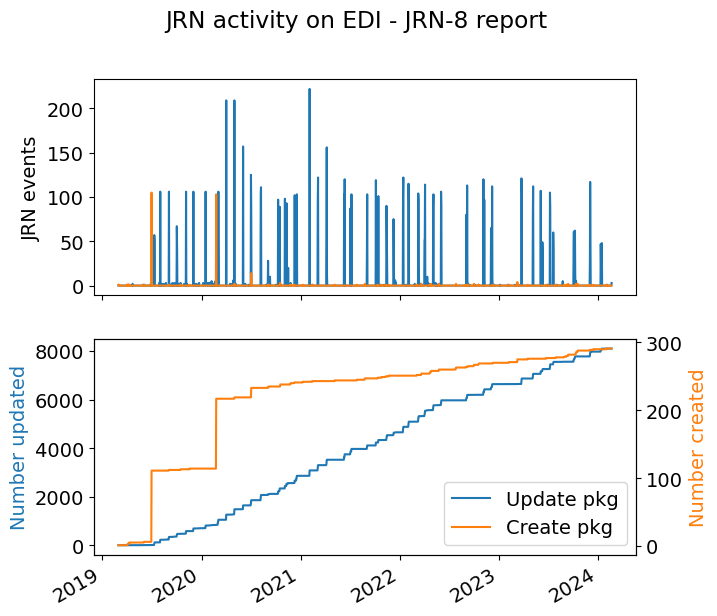

In [13]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update, label='Update pkg')
ax[0].plot(daily.index, daily.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily.index, daily.n_update.cumsum(), label='Update pkg')
plt.ylabel('Number updated', color='C0')
ax2 = ax[1].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create pkg', color='C1')
#ax[1].plot(daily.index, daily.n_tot.cumsum(), label='Total')

plt.ylabel('Number created', color='C1')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI - {0} report'.format(reportname))
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
import os
fig.savefig(os.path.expanduser("~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_{1}.png".format(reportname, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

### Total number of packages

In [14]:
daily.n_create.sum()

291

In [15]:
daily.n_update.sum()

8099

## Plot annual activity excluding Met

In [16]:
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
daily_nomet = edi.counts_to_daily(df.loc[nomet], fromdt=start_rpt)

daily_nomet.head()

,n_update,n_create,n_tot
date,,,
2019-04-02,1,1,1
2019-04-03,0,0,0
2019-04-04,0,0,0
2019-04-05,0,1,1
2019-04-06,0,0,0


### Total number of packages

In [17]:
daily_nomet.n_create.sum()

68

In [18]:
daily_nomet.n_update.sum()

229

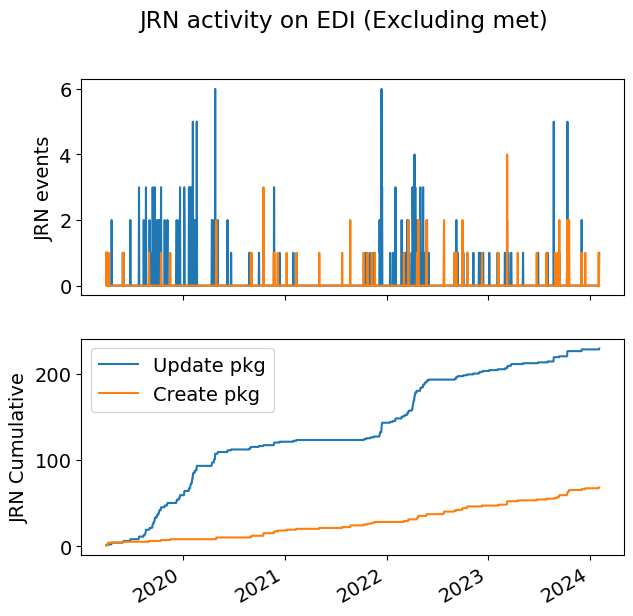

In [19]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_nomet.index, daily_nomet.n_update, label='Update pkg')
ax[0].plot(daily_nomet.index, daily_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_nomet.index, daily_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (Excluding met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_rpt_NoMet_{1}.png".format(reportname, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Summary since last Annual Report

In [20]:
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2019-03-01 12:53:17.423,2019-03-01T12:53:17.423,210437040,createDataPackage,0,1,0,1,437
2019-04-02 14:07:37.967,2019-04-02T14:07:37.967,210351003,createDataPackage,0,1,0,1,351
2019-04-02 17:18:54.615,2019-04-02T17:18:54.615,210351003,updateDataPackage,1,0,0,0,351
2019-04-05 14:47:35.236,2019-04-05T14:47:35.236,210328003,createDataPackage,0,1,0,1,328
2019-04-08 14:03:09.964,2019-04-08T14:03:09.964,210328003,updateDataPackage,1,0,0,0,328


In [21]:
# Unique packages updated (excluding met)
rEDI = df.copy()
rEDI_nomet = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.studyid!='548'),:]
print(len(rEDI.loc[rEDI.action=='updateDataPackage',]))
uniqueUp = rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp_nomet = rEDI_nomet.loc[rEDI_nomet.action=='updateDataPackage',].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
print(uniqueUp)
print(uniqueUp_nomet)
print(len(uniqueUp))
len(uniqueUp_nomet)

8099
[210351003 210328003 210328001 210120001 210127001 210380001 210288001
 210437040 210437031 210437016 210437046 210437061 210437001 210437091
 210437076 210437032 210437017 210437047 210437062 210437002 210437077
 210437092 210437033 210437018 210437048 210437063 210437003 210437093
 210437078 210437034 210437019 210437049 210437064 210437004 210437094
 210437079 210437106 210437035 210437020 210437050 210437065 210437005
 210437095 210437080 210437036 210437021 210437051 210437066 210437006
 210437096 210437081 210437037 210437022 210437052 210437067 210437007
 210437082 210437097 210437038 210437008 210437023 210437053 210437068
 210437098 210437083 210437039 210437024 210437054 210437069 210437009
 210437099 210437084 210437025 210437055 210437070 210437010 210437085
 210437100 210437011 210437041 210437026 210437056 210437071 210437086
 210437101 210437042 210437027 210437057 210437072 210437012 210437087
 210437102 210437043 210437028 210437058 210437073 210437013 210437103
 

116

In [22]:
pkgtbl = pd.DataFrame({'Total':[daily.n_create.sum(), daily.n_update.sum(),len(uniqueUp)],
                       'Non-Met':[daily_nomet.n_create.sum(), daily_nomet.n_update.sum(),len(uniqueUp_nomet)]})
pkgtbl.index = ['New packages created', 'Package updates', 'Unique package updates']

print(pkgtbl)
# Write it
with open('tables_out/{}_rpt_edi.csv'.format(reportname), 'w') as f:
    f.write(pkgtbl.to_csv())

                        Total  Non-Met
New packages created      291       68
Package updates          8099      229
Unique package updates    339      116


In [21]:
uniqueUp2 = ['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=' + str(s)
             for s in uniqueUp]
with open('tables_out/{0}_unique_EDI_updates_{1}.txt'.format(reportname, now), 'w') as f:
    for item in uniqueUp2:
        f.write("%s\n" % item)
        
uniqueUp2


['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548016',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548031',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548076',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548046',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548025',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548061',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548001',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548040',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548085',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548055',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548099',

## Audit reporting

In [22]:
edia.request_audit(210011003)

Requesting access data for knb-lter-jrn.210011003
https://pasta.lternet.edu/audit/reads/knb-lter-jrn/210011003

    


,scope,identifier,revision,resource,total_reads,non_robot_reads
0,knb-lter-jrn,210011003,60,report,47,47
1,knb-lter-jrn,210011003,60,metadata,333,331
2,knb-lter-jrn,210011003,60,data,15,15
3,knb-lter-jrn,210011003,60,dataPackage,121,119
4,knb-lter-jrn,210011003,63,archive,2,2
5,knb-lter-jrn,210011003,63,report,68,67
6,knb-lter-jrn,210011003,63,dataPackage,234,230
7,knb-lter-jrn,210011003,63,data,22,22
8,knb-lter-jrn,210011003,63,metadata,405,400
9,knb-lter-jrn,210011003,101,data,52,52


In [23]:
# Get credentials - these could be anywhere....
import pyEDIutils.edicred as cred

In [44]:
# Get public data downloads for a scope from EDI audit report
# Sometimes this takes 2 tries
test = edia.request_audit_report('readDataEntity', cred.dn, cred.pw,
                               user='public', group=None,resid='knb-lter-jrn',
                               fromdt=start_rpt, todt=end_rpt,lim=1000000)

Requesting audit report for knb-lter-jrn starting 2020-03-05
https://pasta.lternet.edu/audit/report/?category=info&service=DataPackageManager-1.0&serviceMethod=readDataEntity&user=public&authSystem=https%3A%2F%2Fpasta.edirepository.org%2Fauthentication&resourceId=knb-lter-jrn&fromTime=2020-03-05&toTime=2024-03-14&limit=1000000




In [45]:
# What are the unique useragents and which should we screen out?
test.useragent.unique()

array(['Apache-HttpClient/4.3.3 (java 1.5)',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
       'Mozilla/5.0 (X11; Linux x86_64; rv:68.0) Gecko/20100101 Firefox/68.0',
       'lua-resty-http/0.10 (Lua) ngx_lua/10000',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:72.0) Gecko/20100101 Firefox/72.0',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.100 Safari/537.36',
       'DataONE-Python/3.4.7 +http://dataone.org/',
       'Mozilla/5.0 (Windows NT 6.3; Win

In [80]:
np.array([True]).dtype

dtype('bool')

In [70]:
#Exclude DataOne, curl, and python-request agents, which are most likely not 'real users'
searchfor = ['DataONE', 'python-requests', 'curl', 'Turnitin', ]
auto_agents = test.useragent.str.contains('|'.join(searchfor), regex=True)
print(len(test))
test_filt = test.loc[~auto_agents, :]
print(len(test_filt))

65892


KeyError: "None of [Index([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,\n       ...\n       -1, -1, -2, -1, -1, -1, -2, -1, -1, -2],\n      dtype='object', length=65874)] are in the [index]"

In [57]:
# Calculate the daily values
test_filt.index = pd.to_datetime(test_filt.entry_dt)
test_filt['n'] = 1
print('Average daily public downloads: ', test_filt.shape[0]/365)
test_filt.head()

Average daily public downloads:  84.23561643835616


/tmp/ipykernel_1090985/1446458488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filt['n'] = 1


,entry_dt,method,resource_id,user,group,useragent,n
entry_dt,,,,,,,
2020-03-05 15:17:17,2020-03-05T15:17:17,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Apache-HttpClient/4.3.3 (java 1.5),1
2020-03-05 15:17:29,2020-03-05T15:17:29,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Apache-HttpClient/4.3.3 (java 1.5),1
2020-03-05 19:49:49,2020-03-05T19:49:49,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Apache-HttpClient/4.3.3 (java 1.5),1
2020-03-05 20:10:12,2020-03-05T20:10:12,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Apache-HttpClient/4.3.3 (java 1.5),1
2020-03-05 20:22:54,2020-03-05T20:22:54,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Apache-HttpClient/4.3.3 (java 1.5),1


In [58]:
dl = test_filt.n.resample('D').count()
dl.head()

entry_dt
2020-03-05    10
2020-03-06    16
2020-03-07     0
2020-03-08     0
2020-03-09     0
Freq: D, Name: n, dtype: int64

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

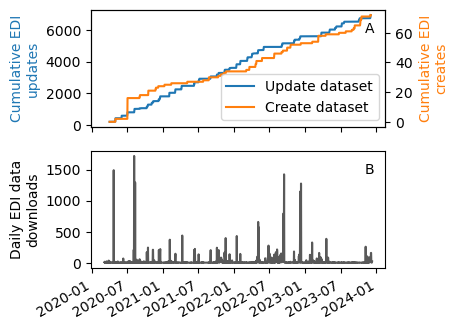

In [69]:
font = {'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3.8, 3.8), sharex=True)

ax[0].plot(daily.index, daily.n_update.cumsum(), label='Update dataset')
ax2 = ax[0].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create dataset', color='C1')
ax[0].set_ylabel('Cumulative EDI\nupdates', color='C0')
ax2.set_ylabel('Cumulative EDI\ncreates', color='C1')
ax2.text(0.93, 0.8, 'A', transform=ax2.transAxes) 
#ax[0].legend()
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

ax[1].plot(dl, label='Download pkg', color='0.35')
#ax[1].plot(dl.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

ax[1].set_ylabel('Daily EDI data\ndownloads')
ax[1].text(0.93, 0.8, 'B', transform=ax[1].transAxes) 
fig.autofmt_xdate()
fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_rpt2_{1}.png".format(reportname,now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Get a list of packages updated within the date range

NOTE: this only works for the current annual report! Many packages get updated once per year at least, so they don't show up when running a previous year annual report.

The list is still available in the yearly "AR_unique_EDI_updates.csv"

If we could check prior revisions....

In [33]:
st = pd.to_datetime(start_rpt).isoformat() + 'Z'
en = pd.to_datetime(end_rpt).isoformat() + 'Z'
en

'2023-11-30T00:00:00Z'

In [34]:
import pyEDIutils.search as edis
updates = edis.search_pasta(query=['scope:knb-lter-jrn', 'pubdate:[{0} TO {1}]'.format(st, en)],
                  fields=('packageid','title','pubdate','keyword','author','begindate','enddate','doi'),
                  sortby='packageid,desc')
updates.to_csv('tables_out/{0}_PASTA_updates_solrsearch_{1}.csv'.format(reportname, now))
updates

https://pasta.lternet.edu/package/search/eml?defType=edismax&q=%2A&fq=scope%3Aknb-lter-jrn&fq=pubdate%3A%5B2022-12-01T00%3A00%3A00Z+TO+2023-11-30T00%3A00%3A00Z%5D&fl=packageid%2Ctitle%2Cpubdate%2Ckeyword%2Cauthor%2Cbegindate%2Cenddate%2Cdoi&sort=packageid%2Cdesc&rows=500


,packageid,title,pubdate,keywords,authors,begindate,enddate,doi
0,knb-lter-jrn.210586002.3,Dataset and analyses for publication entitled:...,2023,inorganic nutrients;organic matter;grasslands;...,"Currier, Courtney;Reichmann, Lara;Sala, Osvaldo E",1876-01-01,2021-12-31,doi:10.6073/pasta/f2c47d19074337832ee4e720e2a0...
1,knb-lter-jrn.210586001.3,Soil and foliar carbon and nitrogen content an...,2023,inorganic nutrients;organic matter;grasslands;...,"Currier, Courtney;Reichmann, Lara;Sala, Osvaldo E",2011-06-01,2020-09-30,doi:10.6073/pasta/8929d93801db656ae1ad0f3a12a1...
2,knb-lter-jrn.210548103.28,Jornada Basin LTER Cross-scale Interactions St...,2023,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2023-09-21,doi:10.6073/pasta/029c896133cb4571259ffe077822...
3,knb-lter-jrn.210548102.27,Jornada Basin LTER Cross-scale Interactions St...,2023,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2023-09-21,doi:10.6073/pasta/e1236353b6a15d53aa8864788236...
4,knb-lter-jrn.210548101.28,Jornada Basin LTER Cross-scale Interactions St...,2023,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2023-09-21,doi:10.6073/pasta/5fa75fe767589be1baaaa57e85de...
...,...,...,...,...,...,...,...,...
251,knb-lter-jrn.200047001.3,Map of ecological sites and ecological states ...,2023,plant communities;vegetation dynamics;Jornada ...,"Burkett, Laura M;Bestelmeyer, Brandon T",2014-01-01,2021-03-31,doi:10.6073/pasta/ad172f22b0abb8fad0998e34bca1...
252,knb-lter-jrn.200043001.1,Jornada Experimental Range (USDA-ARS) monthly ...,2023,Jornada Experimental Range;goat;horse;sheep;LT...,"Ragosta, John P;Havstad, Kris;Bestelmeyer, Bra...",1915-06-01,1952-12-31,doi:10.6073/pasta/2254860ed7a15c1016e24385700a...
253,knb-lter-jrn.200034001.1,Supplemental materials of the Castaño-Sánchez ...,2023,Raramuri Criollo;grain finishing;beef producti...,"Castaño-Sánchez, Jose P.;Rotz, C. Alan;McIntos...",2020-07-01,2020-11-05,doi:10.6073/pasta/7afd0b152f5795b63dba4cb1941c...
254,knb-lter-jrn.200021001.5,Data to explore circular manureshed management...,2023,crop-livestock integration;manureshed;LTAR;ani...,"Spiegal, Sheri;Vendramini, João M.B.;Bittman, ...",2010-01-01,2019-12-31,doi:10.6073/pasta/6025924b89e313f25bddf1912c8a...
